In [1]:
import pandas as pd
import country_converter as coco
from functools import reduce
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.utils import from_networkx
import torch

In [2]:
# Polity IV Index
polity_pd=pd.read_csv("../../../data/polity/democracy_index_polity.csv")
# Correlates of War Alliances
cow_pd=pd.read_csv("../../../data/cow_alliances/alliance_v4.1_by_dyad.csv")
# Worldwide Governance Indicators
wgi_pd=pd.read_csv("../../../data/world_bank_gi/wgidataset.csv", encoding="utf-8", sep=';')
# Varieties of Democracy
vdem_pd=pd.read_csv("../../../data/v-dem/V-Dem-CY-Core-v15.csv")
# Gini
gini_pd=pd.read_csv("../../../data/gini/API_SI.POV.GINI_DS2_en_csv_v2_38260.csv", skiprows=4 )

In [3]:
gini_pd["Country Name"]=coco.convert(names=gini_pd['Country Name'], to='ISO3')

Africa Eastern and Southern not found in regex
Africa Western and Central not found in regex
Arab World not found in regex
Central Europe and the Baltics not found in regex
Channel Islands not found in regex
Caribbean small states not found in regex
East Asia & Pacific ( not found in regex
Early-demographic dividend not found in regex
East Asia & Pacific not found in regex
Europe & Central Asia ( not found in regex
Europe & Central Asia not found in regex
Euro area not found in regex
European Union not found in regex
Fragile and conflict affected situations not found in regex
High income not found in regex
Heavily indebted poor countries (HIPC) not found in regex
IBRD only not found in regex
IDA & IBRD total not found in regex
IDA total not found in regex
IDA blend not found in regex
IDA only not found in regex
Not classified not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean not found in regex
Least developed countries: UN classification not fo

In [4]:
gini_pd=gini_pd[
    (gini_pd['Country Name'] != "not found") &
    (~gini_pd['Country Name'].apply(lambda x: isinstance(x, list)))]

In [5]:
gini_pd = gini_pd.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="year",
    value_name="gini"
)

In [6]:
gini_pd=gini_pd[gini_pd["year"]!="Unnamed: 69"]
gini_pd.rename(columns={"Country Name":"country"}, inplace=True)
gini_pd['year'] = pd.to_numeric(gini_pd['year'], errors='coerce')
gini_pd=gini_pd[["country", "year", "gini"]]

In [7]:
gini_pd.to_parquet("data/gini.parquet")

### Prepping the Polity Dataframe

In [8]:

custom_map = {
    "West Germany":"Germany",
    'USSR': 'Russia',
    "Democratic Republic of Vietnam": "Vietnam"
}
polity_pd['Entity'] = polity_pd['Entity'].replace(custom_map)
polity_pd["entity_convert"]=coco.convert(names=polity_pd['Entity'], to='name_short')
polity_pd=polity_pd[polity_pd["entity_convert"]!="not found"]

Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not f

In [9]:
polity_pd=polity_pd[["entity_convert", "Year","Democracy"]]
polity_pd.rename(columns={"entity_convert":"country", "Year":"year"}, inplace=True)

In [10]:
polity_pd[polity_pd.duplicated(subset=["country", "year"], keep=False)].sort_values(by=["country", "year"])

,country,year,Democracy
4388,Colombia,1832,2.0
8259,Colombia,1832,-5.0
5192,Czechia,1918,7.0
5286,Czechia,1918,7.0
5193,Czechia,1919,7.0
...,...,...,...
22549,Yemen,1989,-5.0
22573,Yemen,1989,-7.0
22449,Yemen,1990,0.0
22550,Yemen,1990,-5.0


In [11]:
# This handles duplicates for countries with two entries for territory/year combination
polity_pd = (
    polity_pd
    .groupby(['country', 'year'], as_index=False)
    .mean(numeric_only=True)
)

### Prepping COW dataframe

In [12]:
cow_pd

,version4id,ccode1,state_name1,ccode2,state_name2,dyad_st_day,dyad_st_month,dyad_st_year,dyad_end_day,dyad_end_month,dyad_end_year,left_censor,right_censor,defense,neutrality,nonaggression,entente,asymmetric,version
0,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,NaN,1,1,1,0,1,0.0,0,4.1
1,2,200,United Kingdom,380,Sweden,1,1,1816,15.0,2.0,1911.0,1,0,0,0,0,1.0,0,4.1
2,3,240,Hanover,245,Bavaria,1,1,1838,15.0,3.0,1848.0,0,0,1,0,1,1.0,0,4.1
3,3,240,Hanover,245,Bavaria,29,11,1850,15.0,6.0,1866.0,0,0,1,0,1,1.0,0,4.1
4,3,240,Hanover,255,Germany,1,1,1838,15.0,3.0,1848.0,0,0,1,0,1,1.0,0,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3217,410,365,Russia,370,Belarus,3,2,2009,NaN,NaN,NaN,0,1,1,0,0,0.0,0,4.1
3218,411,365,Russia,371,Armenia,20,8,2010,NaN,NaN,NaN,0,1,1,0,0,1.0,1,4.1
3219,412,625,Sudan,626,South Sudan,10,2,2012,27.0,3.0,2012.0,0,0,0,0,1,0.0,0,4.1
3220,413,651,Egypt,666,Israel,26,3,1979,NaN,NaN,NaN,0,1,0,0,1,0.0,0,4.1


In [13]:
cow_pd=cow_pd[(cow_pd["dyad_st_year"]>=1945)]

In [14]:
cow_pd.loc[cow_pd['state_name1'] == 'German Federal Republic', 'state_name1'] = "Germany"
cow_pd.loc[cow_pd['state_name2'] == 'German Federal Republic', 'state_name2'] = "Germany"
cow_pd["state1_convert"]=coco.convert(names=cow_pd["state_name1"], to='name_short')
cow_pd["state2_convert"]=coco.convert(names=cow_pd["state_name2"], to='name_short')
cow_pd['dyad_end_year'] = cow_pd['dyad_end_year'].astype('Int64')

Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Dem

In [15]:
cow_pd.dropna(subset=['state1_convert', "state2_convert"], inplace=True)
cow_pd=cow_pd[(cow_pd["state1_convert"]!="not found") & (cow_pd["state2_convert"]!="not found")]
cow_pd["dyad_end_year"]=cow_pd["dyad_end_year"].fillna(2025)

C:\Users\jonas\AppData\Local\Temp\ipykernel_18124\2058092961.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cow_pd.dropna(subset=['state1_convert', "state2_convert"], inplace=True)


In [16]:
cow_pd=cow_pd[["state1_convert", "state2_convert", "dyad_st_year","dyad_end_year", "left_censor", "right_censor", "defense", "neutrality", "nonaggression", "entente", "asymmetric"]]

In [17]:
cow_pd.drop_duplicates(inplace=True)

### Prepping WGI Governance Indicator

In [18]:
wgi_pd["country_convert"]=coco.convert(names=wgi_pd['countryname'], to='name_short')
wgi_pd=wgi_pd[wgi_pd["country_convert"]!="not found"]
wgi_pd.sort_values("country_convert",ascending=True)

Netherlands Antilles (former) not found in regex
Netherlands Antilles (former) not found in regex
Netherlands Antilles (former) not found in regex
Netherlands Antilles (former) not found in regex
Netherlands Antilles (former) not found in regex
Netherlands Antilles (former) not found in regex
Netherlands Antilles (former) not found in regex
Netherlands Antilles (former) not found in regex
Netherlands Antilles (former) not found in regex
Netherlands Antilles (former) not found in regex
Netherlands Antilles (former) not found in regex
Netherlands Antilles (former) not found in regex
Netherlands Antilles (former) not found in regex
Netherlands Antilles (former) not found in regex
Netherlands Antilles (former) not found in regex
Netherlands Antilles (former) not found in regex
Netherlands Antilles (former) not found in regex
Netherlands Antilles (former) not found in regex
Netherlands Antilles (former) not found in regex
Netherlands Antilles (former) not found in regex
Netherlands Antilles

,codeindyr,code,countryname,year,indicator,estimate,stddev,nsource,pctrank,pctranklower,pctrankupper,country_convert
0,AFGcc1996,AFG,Afghanistan,1996,cc,"-1,29","0,34",2,"4,3","0,0","27,4",Afghanistan
14766,AFGrl2010,AFG,Afghanistan,2010,rl,"-1,87","0,18",10,"0,5","0,0","2,4",Afghanistan
30174,AFGrl2022,AFG,Afghanistan,2022,rl,"-1,66","0,17",9,"5,2","1,4","7,1",Afghanistan
14980,AFGrq2010,AFG,Afghanistan,2010,rq,"-1,52","0,18",6,"5,7","2,4","9,1",Afghanistan
856,AFGrq1996,AFG,Afghanistan,1996,rq,"-2,09","0,39",1,"1,6","0,0","6,0",Afghanistan
...,...,...,...,...,...,...,...,...,...,...,...,...
20971,ZWEge2015,ZWE,Zimbabwe,2015,ge,"-1,25","0,17",12,"9,0","4,8","16,7",Zimbabwe
20757,ZWEcc2015,ZWE,Zimbabwe,2015,cc,"-1,34","0,13",15,"6,7","1,9","11,9",Zimbabwe
20543,ZWEva2014,ZWE,Zimbabwe,2014,va,"-1,26","0,12",14,"13,8","7,4","20,2",Zimbabwe
20115,ZWErl2014,ZWE,Zimbabwe,2014,rl,"-1,44","0,14",15,"3,8","1,4","7,2",Zimbabwe


In [19]:
wgi_pd=wgi_pd[["country_convert","year", "estimate"]]
wgi_pd.rename(columns={"country_convert":"country"}, inplace=True)
wgi_pd["estimate"]=wgi_pd["estimate"].replace("..", np.nan).str.replace(",", ".", regex=False) 
wgi_pd["estimate"]=pd.to_numeric(wgi_pd["estimate"], errors="coerce")

wgi_pd=wgi_pd.groupby(['country', 'year'])['estimate'].mean().dropna().reset_index()


### Prepping V-Dem Democracy Indices

In [20]:
vdem_pd=vdem_pd[["country_name", "country_text_id", "country_id", "year", 
                 "v2x_polyarchy", #electoral democracy index
                 "v2x_libdem", #liberal democracy index
                 "v2x_partipdem", #participatory democracy index
                 "v2x_delibdem", #deliberative democracy index
                 "v2x_egaldem" #egalitarian democracy index
                 ]]

In [21]:
vdem_pd["country_name_converted"]=coco.convert(names=vdem_pd['country_name'], to='name_short')
vdem_pd=vdem_pd[vdem_pd["country_name_converted"]!="not found"]

Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not f

In [22]:
vdem_pd=vdem_pd[["country_name_converted","year", "v2x_polyarchy", "v2x_libdem","v2x_partipdem","v2x_delibdem","v2x_egaldem"]]
vdem_pd.rename(columns={"country_name_converted":"country"}, inplace=True)


In [23]:
# This handles duplicates for countries with two entries for territory/year combination
vdem_pd = (
    vdem_pd
    .groupby(['country', 'year'], as_index=False)
    .mean(numeric_only=True)
)

### Joining node features

In [214]:

dfs = [vdem_pd, polity_pd, wgi_pd]

feature_nodes = reduce(
    lambda left, right: pd.merge(left, right, on=["country", "year"], how="outer"),
    dfs
)

In [215]:
feature_nodes["country"]=coco.convert(names=feature_nodes["country"], to='ISO3')

In [216]:
# Interpolation of countries along time dimension

columns_to_interpolate = ['v2x_polyarchy', 'v2x_libdem', 'v2x_partipdem', 'v2x_delibdem', 'v2x_egaldem', 'Democracy', 'estimate']

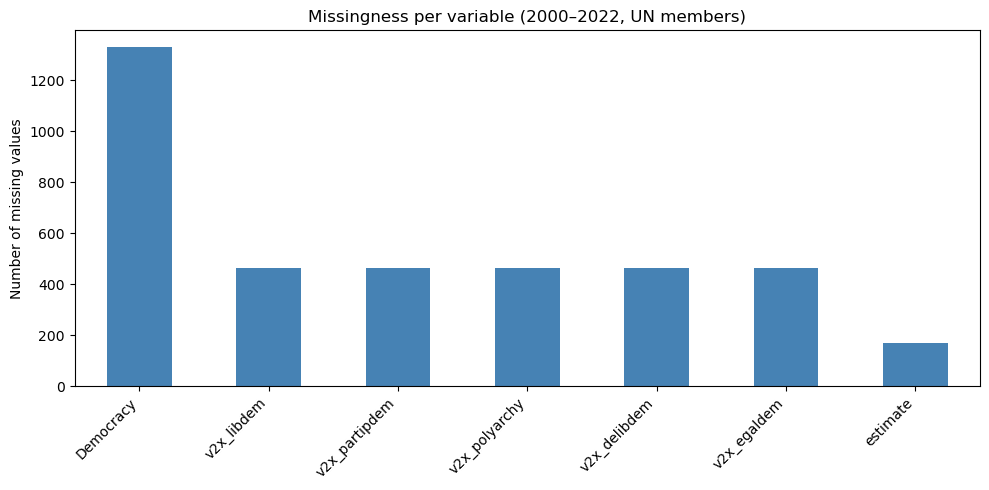

In [217]:
### Plotting missingness in feature nodes: 
def get_un_countries():
    """Cache UN member countries to avoid repeated lookups"""
    iso3 = coco.CountryConverter().data[coco.CountryConverter().data['UNmember'].notna()]['ISO3'].dropna().tolist()
    unnumeric = coco.CountryConverter().data[coco.CountryConverter().data['UNmember'].notna()]['UNcode'].dropna().tolist()
    return iso3, unnumeric


scope_nodes = feature_nodes[feature_nodes["year"].between(2000, 2022)]

# Get UN members
un_iso3, un_numeric = get_un_countries()

# --- choose depending on your "country" column format ---
if scope_nodes["country"].dtype == "object":  
    # likely ISO3 codes
    scope_nodes = scope_nodes[scope_nodes["country"].isin(un_iso3)]
else:  
    # likely numeric UN codes
    scope_nodes = scope_nodes[scope_nodes["country"].isin(un_numeric)]

missing_counts = scope_nodes.isna().sum()
missing_counts = missing_counts[missing_counts > 0]

plt.figure(figsize=(10,5))
missing_counts.sort_values(ascending=False).plot.bar(color="steelblue")
plt.ylabel("Number of missing values")
plt.title("Missingness per variable (2000–2022, UN members)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

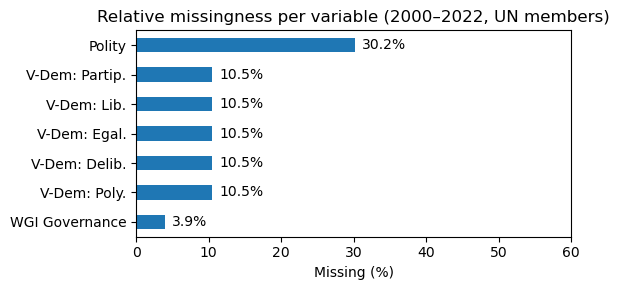

In [218]:
# Relative missingness

# Columns to exclude from missingness stats (adjust if needed)
exclude = {"country", "year"}
cols = [c for c in scope_nodes.columns if c not in exclude]

# Relative missingness (fraction) per column
missing_frac = scope_nodes[cols].isna().mean()

# Keep only columns with any missingness
missing_frac = missing_frac[missing_frac > 0].sort_values(ascending=True)  # ascending for nicer horiz plot

# Convert to percent
missing_pct = (missing_frac * 100).round(1)
missing_pct = missing_pct.rename(index={"Democracy": "Polity",
                                        "estimate":"WGI Governance",
                                        "v2x_partipdem":"V-Dem: Partip.",
                                        "v2x_libdem":"V-Dem: Lib.",
                                        "v2x_egaldem":"V-Dem: Egal.",
                                        "v2x_delibdem":"V-Dem: Delib.",
                                        "v2x_polyarchy":"V-Dem: Poly."})

# Horizontal bar plot
plt.figure(figsize=(6, 3))
ax = missing_pct.plot.barh()
ax.set_xlabel("Missing (%)")
ax.set_ylabel("")
ax.set_title("Relative missingness per variable (2000–2022, UN members)")
ax.set_xlim(0, 60)

# Add percentage labels at the end of bars
for i, v in enumerate(missing_pct.values):
    ax.text(v + 1, i, f"{v:.1f}%", va="center")  # +1 for spacing; adjust if axis too tight

plt.tight_layout()
plt.show()


In [219]:

# Make sure data is sorted by group and time
feature_nodes = feature_nodes.sort_values(['country', 'year'])

# Apply interpolation to each column
for col in columns_to_interpolate:
    feature_nodes[col] = feature_nodes.groupby('country')[col].transform(
        lambda g: g.interpolate(method='linear', limit_direction='both')
    )

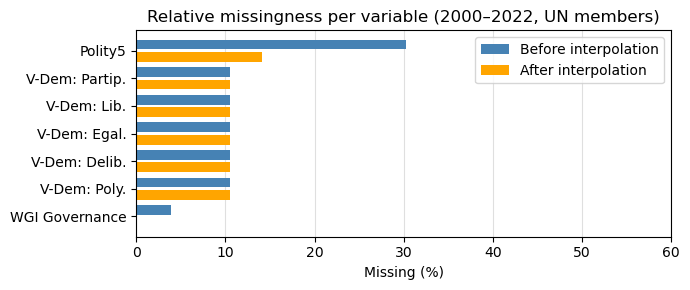

In [227]:
import numpy as np
import matplotlib.pyplot as plt

# --- helper: UN + year filter ---
def filter_scope(df):
    scope = df[df["year"].between(2000, 2022)].copy()
    un_iso3, un_numeric = get_un_countries()
    if scope["country"].dtype == "object":
        scope = scope[scope["country"].isin(un_iso3)]
    else:
        scope = scope[scope["country"].isin(un_numeric)]
    return scope

# filter before/after interpolation
scope_before = filter_scope(scope_nodes)       # before interpolation
scope_after  = filter_scope(feature_nodes)     # after interpolation

# relative missingness
exclude = {"country", "year"}
cols = [c for c in scope_after.columns if c not in exclude and c in scope_before.columns]
miss_before = scope_before[cols].isna().mean()
miss_after  = scope_after[cols].isna().mean()

mask_any = (miss_before > 0) | (miss_after > 0)
miss_before, miss_after = miss_before[mask_any], miss_after[mask_any]

order = miss_before.sort_values(ascending=True).index
miss_before, miss_after = miss_before.loc[order], miss_after.loc[order]

rename_map = {
    "Democracy": "Polity5",
    "estimate": "WGI Governance",
    "v2x_partipdem": "V-Dem: Partip.",
    "v2x_libdem":   "V-Dem: Lib.",
    "v2x_egaldem":  "V-Dem: Egal.",
    "v2x_delibdem": "V-Dem: Delib.",
    "v2x_polyarchy":"V-Dem: Poly.",
}
pct_before = (miss_before * 100).round(1).rename(index=rename_map)
pct_after  = (miss_after  * 100).round(1).rename(index=rename_map)
pct_after = pct_after.reindex(pct_before.index).fillna(0)

# plot
import numpy as np
import matplotlib.pyplot as plt

# positions: one tick per variable
y = np.arange(len(pct_before))
h = 0.35   # bar thickness
gap = 0.10 # small gap between before/after

plt.figure(figsize=(7,3))
ax = plt.gca()

# before = top bar
ax.barh(y + h/2 + gap/2, pct_before.values, height=h, label="Before interpolation", color="steelblue", alpha=1)
# after = bottom bar
ax.barh(y - h/2 - gap/2, pct_after.values,  height=h, label="After interpolation", color="orange", alpha=1)

ax.set_xlabel("Missing (%)")
ax.set_yticks(y)
ax.set_yticklabels(pct_before.index)   # one label per pair
ax.set_xlim(0, 60)
ax.set_title("Relative missingness per variable (2000–2022, UN members)")
ax.set_axisbelow(True)
ax.grid(axis="x", linestyle="-", alpha=0.4)

ax.legend(loc="upper right", frameon=True)
plt.tight_layout()
plt.show()



In [190]:
feature_nodes = feature_nodes[(feature_nodes["year"] >= 2000) & (feature_nodes["year"] <= 2022)]
feature_nodes.dropna(inplace=True)

### Edge Features 

In [85]:
cow_pd["state1_convert"]=coco.convert(names=cow_pd["state1_convert"], to='ISO3')
cow_pd["state2_convert"]=coco.convert(names=cow_pd["state2_convert"], to="ISO3")

### Constructing the graph

In [87]:
cow_pd['active_years'] = cow_pd.apply(lambda row: list(range(row['dyad_st_year'], row['dyad_end_year'] + 1)), axis=1)


In [88]:
edges_expanded=cow_pd.explode("active_years")
edges_expanded = edges_expanded.rename(columns={'active_years': 'year',
                                                "state1_convert":"state1",
                                                "state2_convert":"state2"})

# Step 4: Drop start and end years if you no longer need them
edges_expanded = edges_expanded.drop(columns=["dyad_st_year","dyad_end_year","left_censor", "right_censor"])


new_position = 2  # zero-based index

cols = list(edges_expanded.columns)
cols.insert(new_position, cols.pop(cols.index("year")))
edges_expanded=edges_expanded[cols]

edges_expanded=edges_expanded[(edges_expanded["year"]<=2022) & (edges_expanded["year"]>=2000)]

In [94]:
edges_merged = edges_expanded.groupby(
    ["state1", "state2", "year"], as_index=False
)[["defense", "neutrality", "nonaggression", "entente", "asymmetric"]].max()

In [106]:
edges_merged.to_parquet("data/edge_features.parquet")

In [108]:
feature_nodes.to_parquet("data/node_features.parquet")

In [109]:
nodes_pd=pd.read_parquet("data/node_features.parquet")
edges_pd=pd.read_parquet("data/edge_features.parquet")